# Does the recording's duration affect the quality of spike sorting?

This notebook investigates if and how the duration of the recording affects spike sorting.

Obviously, each sorter engine needs a minimum number of events to detect a "cluster", and therefore a unit.
If a neuron doesn't fire enough during a recording it won't be detected.
The number of event per units depends on the recording duration and the each individual firing rates.

In order to test this phenomenon, we use the same dataset (with the same neurons and firing rates), but we vary the 
duration of the recording.

The simulated recording is generated with [MEArec](https://github.com/alejoe91/MEArec) using a Neuronexus-32 probe. 
This specific dataset seems  *relatively* easy to sort. The "SYNTH_MEAREC_NEURONEXUS" dataset in 
[SpikeForest](https://spikeforest.flatironinstitute.org/) (which uses the same probe),  in fact, shows quite good 
results for all sorters. The original duration is 600s (10 min).

Here we have generated a new but similar recording with a duration of 1800s. Then we have shortened it to 60s, 300s, 
600s and 1800s (original). The recording can be downloaded from Zenodo: https://doi.org/10.5281/zenodo.4058272

The dataset name is: **recordings_10cells_Neuronexus-32_1800.0_10.0uV_2020-02-28.h5**. It contains 10 neurons recorded on a Neuronexus-32 probe. 
The duration is 1800s and the noise level is 10uV.

Let's see if spike sorters are robust to fewer events and if are able to deal with long durations or they end up 
finding too many events.

Author: [Samuel Garcia](https://github.com/samuelgarcia), CRNL, Lyon

### Requirements

For this need you will need the following Python packages:

- numpy
- pandas
- matplotlib
- seaborn
- spikeinterface

To run the MATLAB-based sorters, you would also need a MATLAB license.
For other sorters, please refer to the documentation on [how to install sorters](https://spikeinterface.readthedocs.io/en/latest/sortersinfo.html).

### Installation and imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw

from spikeinterface.comparison import GroundTruthStudy

/home/samuel/.virtualenvs/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# clone and install MATLAB sorters

# kilosort2
!git clone https://github.com/MouseLand/Kilosort2.git
kilosort2_path = './Kilosort2'
ss.Kilosort2Sorter.set_kilosort2_path(kilosort2_path)

# kilosort
!git clone https://github.com/cortex-lab/KiloSort.git
kilosort_path = './KiloSort'
ss.KilosortSorter.set_kilosort_path(kilosort_path)

# ironclust
!git clone https://github.com/flatironinstitute/ironclust.git
ironclust_path = './ironclust'
ss.IronclustSorter.set_ironclust_path(ironclust_path)

In [2]:
%matplotlib inline

# some matplotlib hack to prettify figure
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', figsize=(10.0, 8.0))  # figsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def clear_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)    

## Check spikeinterface version and sorter version

In [3]:
si.print_spikeinterface_version()
ss.print_sorter_versions()

spikeinterface: 0.9.1
  * spikeextractor: 0.7.2
  * spiketoolkit: 0.5.2
  * spikesorters: 0.2.4
  * spikecomparison: 0.2.3
  * spikewidgets: 0.3.3

herdingspikes: 0.3.7+git.45665a2b6438
ironclust: 5.9.4
kilosort: git-cd040da1963d
kilosort2: git-67a42a87b866
klusta: 3.0.16
mountainsort4: unknown
spykingcircus: 0.9.2
tridesclous: 1.5.0


## Setup global path

In [4]:
# Change this path to point to where you downloaded the dataset
p = Path('/home/samuel/Documents/DataSpikeSorting/mearec/')
study_folder = p / 'study_mearec_neuronexus_several_durations/'

## Setup ground truth study

In [5]:
mearec_filename = p / 'recordings_10cells_Neuronexus-32_1800.0_10.0uV_2020-02-28.h5'

In [ ]:
rec  = se.MEArecRecordingExtractor(mearec_filename, locs_2d=True)
gt_sorting = se.MEArecSortingExtractor(mearec_filename)

fs = rec.get_sampling_frequency()

gt_dict = {}
durations = [60, 300, 600, 1800]
for duration in durations:
    sub_rec = se.SubRecordingExtractor(rec, start_frame=0, end_frame=int(duration*fs))
    sub_sorting = se.SubSortingExtractor(gt_sorting, start_frame=0, end_frame=int(duration*fs))
    gt_dict[f'rec{duration}'] = (sub_rec, sub_sorting)
study = GroundTruthStudy.create(study_folder, gt_dict)


## Run all sorters

In [7]:
sorter_list = ['herdingspikes', 'ironclust', 'kilosort2',  'kilosort',
               'mountainsort4', 'spykingcircus', 'tridesclous'] 

In [ ]:
study = GroundTruthStudy(study_folder)
sorter_params = {} 
study.run_sorters(sorter_list, sorter_params=sorter_params, mode='keep', verbose=True)

## Get signal to noise ratio for all units

Units are the same in each recording so the snr is the same lets take from the longest one

In [42]:

study = GroundTruthStudy(study_folder)
snr = study.get_units_snr(rec_name='rec1800')
snr

snr rec_name
gt_unit_id                    
0           22.270592  rec1800
1            9.222510  rec1800
2            5.939772  rec1800
3           14.853892  rec1800
4            7.504935  rec1800
5            9.803070  rec1800
6           16.042390  rec1800
7           11.883403  rec1800
8            7.490971  rec1800
9            5.482461  rec1800

Text(0.5, 0, 'GT units SNR')

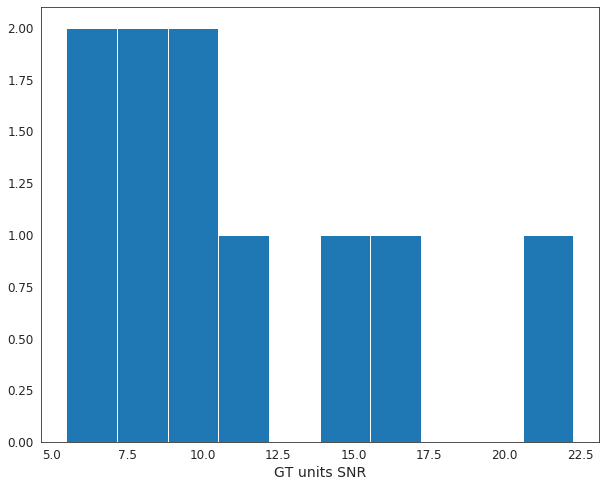

In [43]:
fig, ax = plt.subplots()
ax.hist(snr['snr'].values, bins=10)
ax.set_xlabel('GT units SNR')

## Run comparison with ground truth and retreive result tables

In [102]:
# this copy sorting is necessary to copy results from sorter
# into a centralize folder with all results
study.copy_sortings()

# this run all comparison sto GT
study.run_comparisons(exhaustive_gt=True, match_score=0.1, overmerged_score=0.2)

In [103]:
# this retrieve results
comparisons = study.comparisons
dataframes = study.aggregate_dataframes()

## Run times

In [104]:
run_times = dataframes['run_times']
run_times

rec_name    sorter_name    run_time
0    rec600    tridesclous  118.908889
1    rec300      kilosort2   44.356094
2    rec600       kilosort  119.256738
3   rec1800  mountainsort4  795.946418
4     rec60  herdingspikes    5.698961
5     rec60  spykingcircus   31.770160
6     rec60       kilosort   28.761853
7     rec60    tridesclous   19.454172
8   rec1800  herdingspikes  124.915830
9     rec60  mountainsort4   89.919816
10   rec600  spykingcircus  154.454786
11   rec300  spykingcircus   82.981423
12   rec600      kilosort2   64.552614
13    rec60      kilosort2   24.819330
14   rec600  mountainsort4  327.498347
15   rec300  mountainsort4  197.165915
16   rec300  herdingspikes   21.194948
17  rec1800      ironclust   98.909468
18   rec300       kilosort   67.272793
19   rec300      ironclust   27.962674
20  rec1800      kilosort2  144.794843
21   rec600  herdingspikes   44.548482
22   rec600      ironclust   40.769642
23  rec1800       kilosort  333.402659
24   rec300    tridesclous   66.892407
25  rec1800    tridesclous  383.363512
26    rec60      ironclust   19.337697
27  rec1800  spykingcircus  471.506204

In [105]:
# insert durations
run_times['duration']  = run_times['rec_name'].apply(lambda s: float(s.replace('rec', '')))


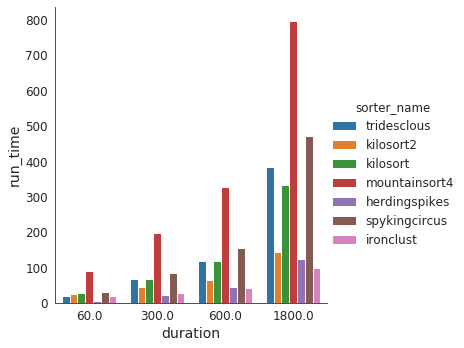

In [106]:
g = sns.catplot(data=run_times, x='duration', y='run_time', hue='sorter_name', kind='bar')

## Accuracy vs duration

In [107]:
perf = dataframes['perf_by_units']
perf

rec_name    sorter_name  gt_unit_id  accuracy    recall precision  \
0     rec600  spykingcircus           0  0.980565  0.980565         1   
1     rec600  spykingcircus           1  0.993337  0.993337         1   
2     rec600  spykingcircus           2  0.832362  0.832824  0.999334   
3     rec600  spykingcircus           3  0.995868  0.995868         1   
4     rec600  spykingcircus           4    0.9933    0.9933         1   
..       ...            ...         ...       ...       ...       ...   
275  rec1800       kilosort           5  0.998887  0.999026  0.999861   
276  rec1800       kilosort           6  0.999045  0.999331  0.999713   
277  rec1800       kilosort           7   0.99865  0.999285  0.999364   
278  rec1800       kilosort           8  0.998279  0.998552  0.999726   
279  rec1800       kilosort           9  0.995271  0.995552  0.999716   

    false_discovery_rate    miss_rate  
0                      0    0.0194346  
1                      0   0.00666263  
2            0.000666445     0.167176  
3                      0   0.00413223  
4                      0   0.00669975  
..                   ...          ...  
275          0.000139315  0.000974388  
276          0.000286834  0.000669024  
277          0.000635627  0.000715023  
278          0.000274187   0.00144757  
279          0.000283597   0.00444805  

[280 rows x 8 columns]

In [108]:
# insert durations
perf['duration']  = perf['rec_name'].apply(lambda s: float(s.replace('rec', '')))


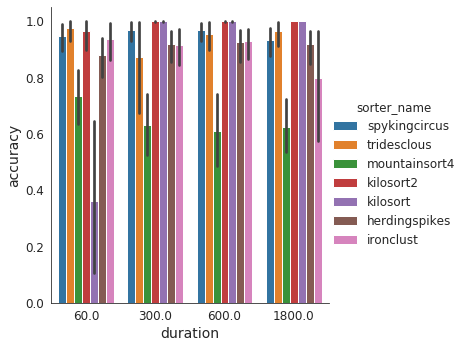

In [109]:
g = sns.catplot(data=perf, x='duration', y='accuracy', hue='sorter_name', kind='bar')

## Count good, bad, false positive units vs duration

In [110]:
count_units = dataframes['count_units']
count_units

rec_name    sorter_name num_gt num_sorter num_well_detected num_redundant  \
0    rec600  spykingcircus     10         27                10             0   
1    rec300    tridesclous     10          9                 8             0   
2   rec1800  mountainsort4     10        199                 2             6   
3    rec300  mountainsort4     10        104                 2             9   
4     rec60      kilosort2     10         13                 9             0   
5     rec60       kilosort     10          5                 3             0   
6   rec1800  herdingspikes     10         71                 9             0   
7   rec1800    tridesclous     10         11                 9             0   
8    rec600  herdingspikes     10         23                 9             0   
9     rec60  mountainsort4     10         60                 4             4   
10   rec300  spykingcircus     10         22                10             0   
11   rec600      ironclust     10         13                 9             0   
12   rec600  mountainsort4     10        133                 2             7   
13   rec600    tridesclous     10         12                 9             0   
14    rec60  spykingcircus     10         20                 9             0   
15   rec300      kilosort2     10         16                10             0   
16   rec600       kilosort     10         11                10             0   
17   rec300      ironclust     10         12                 8             0   
18  rec1800  spykingcircus     10         37                 9             1   
19  rec1800      kilosort2     10         14                10             0   
20  rec1800      ironclust     10         13                 7             0   
21   rec300  herdingspikes     10         15                 9             0   
22   rec300       kilosort     10         11                10             0   
23    rec60  herdingspikes     10         10                 8             0   
24    rec60    tridesclous     10         10                 9             0   
25   rec600      kilosort2     10         16                10             0   
26    rec60      ironclust     10         12                 8             0   
27  rec1800       kilosort     10         11                10             0   

   num_overmerged num_false_positive num_bad  
0               0                 17      17  
1               0                  0       0  
2               0                183     189  
3               0                 85      94  
4               1                  3       3  
5               1                  0       0  
6               0                 61      61  
7               0                  1       1  
8               0                 13      13  
9               0                 46      50  
10              0                 12      12  
11              0                  3       3  
12              0                116     123  
13              0                  2       2  
14              0                 10      10  
15              0                  6       6  
16              0                  1       1  
17              0                  2       2  
18              0                 26      27  
19              0                  4       4  
20              1                  4       4  
21              0                  5       5  
22              0                  1       1  
23              0                  0       0  
24              0                  0       0  
25              0                  6       6  
26              0                  2       2  
27              0                  1       1

In [111]:
# insert durations
count_units['duration']  = count_units['rec_name'].apply(lambda s: float(s.replace('rec', '')))

### num_well_detected vs duration

the more the better

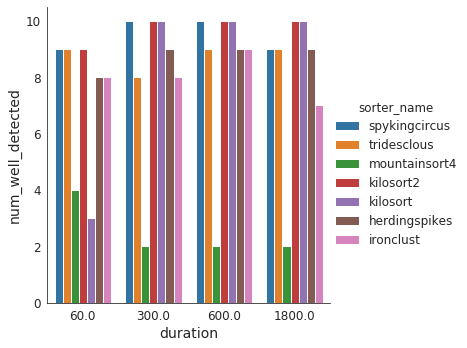

In [112]:

g = sns.catplot(data=count_units, x='duration', y='num_well_detected', hue='sorter_name', kind='bar')

### num_false_positive vs duration

the less the better

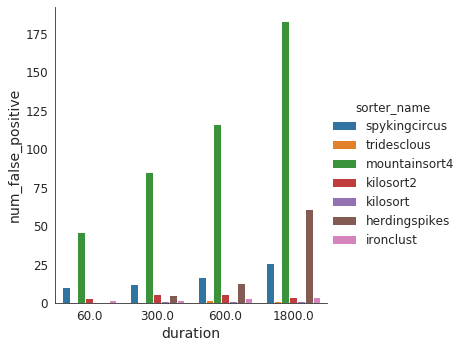

In [113]:
g = sns.catplot(data=count_units, x='duration', y='num_false_positive', hue='sorter_name', kind='bar')

(0, 10)

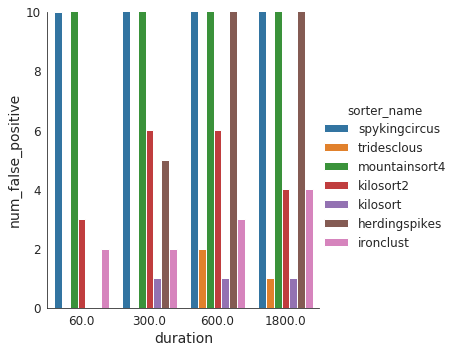

In [114]:
# same as previous but with other limits
g = sns.catplot(data=count_units, x='duration', y='num_false_positive', hue='sorter_name', kind='bar')
g.fig.axes[0].set_ylim(0, 10)

### num_redundant vs duration

the less the better

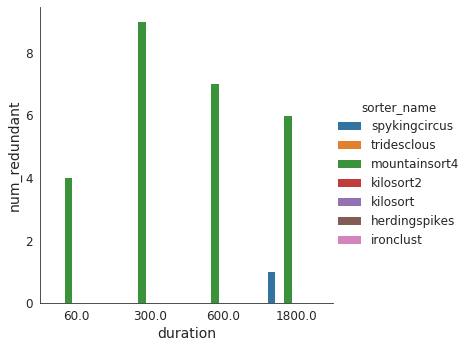

In [115]:
g = sns.catplot(data=count_units, x='duration', y='num_redundant', hue='sorter_name', kind='bar')

## Conlusion

For this simple simulated dataset we have observed that:

  * Focusing on the average accuracy, all sorters have similar performance for long or short recordings.
    The only exception is Kilosort: it has a clear drop in performence for the shortest duration (60s).

  * Very surprinsingly, some sorters (e.g. tridesclous, ironclust) have better performence at 60s than 300s. This  could be specific to this dataset and have to be instigate more.
    
  * Looking at the number of "num_false_positive" and "num_well_detected" the situation is the following:
    
      * kilosort is not affected by the duration
      * herdingspikes (one of the most affected): the longer the duration, the more "num_false_positive"
      * ironclust seems to have a slight increase in "num_false_positive" for longer duration
      * kilosort2 has random oscillations of "num_false_positive" across durations
      * tridesclous has a few more "num_false_positive" for long durations
      * moutainsort is heavily affected by the duration
      * spykingcircus is affected by long durations as more "num_false_positive" units are found
   